**Loading Data**

Initial Steps are just to import & unzip the dataset from kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"haritshandilya","key":"a3b3fc3619ea2aa21d8a587560e99b05"}'}

In [2]:
#before importing the dataset we want to use this code
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d benhamner/nips-papers

 91% 129M/141M [00:04<00:00, 27.2MB/s]
100% 141M/141M [00:04<00:00, 33.1MB/s]


In [27]:
from zipfile import ZipFile
file_name="nips-papers.zip"

with ZipFile (file_name,"r") as zip1:
  zip1.extractall()
  print("Done!")


Done!


**Data**

The NIPS conference (Neural Information Processing Systems) is one of the most prestigious yearly events in the machine learning community. At each NIPS conference, a large number of research papers are published. The data file contains information on the different NIPS papers that were published from 1987 until 2017 (30 years). These papers discuss a wide variety of topics in machine learning, from neural networks to optimization methods and many more.

In [1]:
import pandas as pd
papers = pd.read_csv("papers.csv")
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


**EDA to understand the data**

For the analysis of the papers, we only consider in the text data associated with the paper and the year the paper was published in so that it is necessary to remove all the columns that do not contain useful text information.

In [2]:
# Remove the columns
papers.drop(columns=['id', 'event_type', 'pdf_name'], inplace=True)

# Print out the first rows of papers
papers.head()

,year,title,abstract,paper_text
0,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In order to understand how the machine learning field has evolved over time, we will begin by visualizing the number of publications per year from 1987.

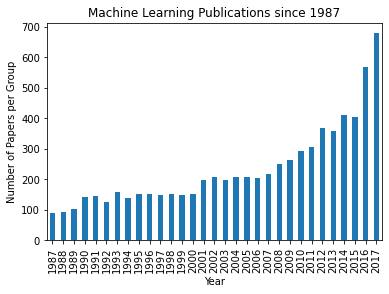

In [3]:
groups = papers.groupby('year')
counts = groups.size()
import matplotlib.pyplot as plt
%matplotlib inline
counts.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of Papers per Group')
plt.title('Machine Learning Publications since 1987')
plt.show()

**Data Preprocessing**

First, we will perform some simple preprocessing on the titles in order to make them more convenient for analysis. We will use a regular expression to remove any punctuation in the title. Then we will lowercase the words.

In [4]:
import re
# Remove punctuation
papers['title_processed'] = papers['title'].map(lambda x: re.sub('[,\.!?]', '', x))
# Lowercase the words
papers['title_processed'] = papers['title_processed'].map(lambda x: x.lower())

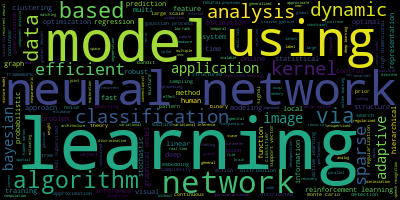

In [5]:
import wordcloud
long_string = " ".join(papers.title_processed)
wordcloud = wordcloud.WordCloud()
wordcloud.generate(long_string)
wordcloud.to_image()

**LDA Analysis**


The main text analysis method that we will use is Latent Dirichlet Allocation (LDA). LDA is able to perform topic detection on large document sets, determining what the main topics are in a large unlabeled set of texts.
First, it is necessary to convert the documents into a simple vector representation. Each entry of a document vector will correspond with the number of times a word occurred in the document. To sum up, we will convert a list of titles into a list of vectors with length equal to the vocabulary. We will plot the 10 most common words based on the list of document vectors.

In [7]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    plt.bar(x_pos, counts,align='center')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.title('10 most common words')
    plt.show()


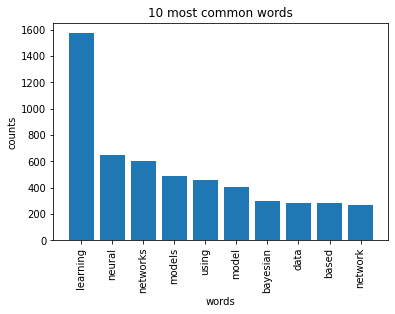

In [8]:
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(papers['title_processed'])
plot_10_most_common_words(count_data, count_vectorizer)

Finally, the research titles will be analyzed using LDA. The only parameter we will change is the number of topics in the LDA algorithm so that we decide to get the top 10 topics. Based on the result we have, we can distinguish what each topic is about (‘neural networks’, ‘learning’, ‘kernel methods’, ‘gaussian processes’).

In [9]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 10
number_words = 6

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
learning networks gaussian neural analysis bayesian

Topic #1:
models learning using structure probabilistic model

Topic #2:
neural networks recognition network using learning

Topic #3:
vector support using multiple visual machines

Topic #4:
learning reinforcement linear optimal deep decision

Topic #5:
learning dynamic matrix online rank programming

Topic #6:
clustering inference sparse variational large scale

Topic #7:
image carlo monte self bandits neurons

Topic #8:
optimization algorithms gradient stochastic convex selection

Topic #9:
learning multi supervised semi spike classification


**Conclusion**

Finally, based on the chart we created before, the number of NIPS conference papers has risen exponentially from 1987 until 2017. We can also conclude that Machine learning has become increasingly popular over the past years. Therefore, the historical data predicts that more papers will publish in 2018!